In [1]:
import os
import sys
sys.path.append("/home/bingxing2/ailab/maiweijian/NeuroFlow/")
sys.path.append("/home/bingxing2/ailab/maiweijian/NeuroFlow/sdxl/")
sys.path.append("/home/bingxing2/ailab/maiweijian/NeuroFlow/sdxl/generative_models")

from dataset import *
from mind_utils import *
from utils import *

In [3]:
import argparse

def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("--data-path", type=str, default="/home/bingxing2/ailab/group/ai4neuro/BrainVL/data/processed_data")
    parser.add_argument("--model-path", type=str, default="vae-nsd-s125-vs1-h4096-softclip-w1000-kl0.001-bs64-244-proj")
    parser.add_argument("--subject", type=str, default="[2]")
    parser.add_argument('--valid_sub', type=int, default=1)
    parser.add_argument('--test_batch_size', type=int, default=64)
    parser.add_argument('--hour', type=int, default=36)

    try:
        args = parser.parse_args()
    except SystemExit:
        # 防止 Notebook 直接运行出错，强制返回默认值
        args = parser.parse_args(args=[])

    return args

args = get_args()

pass

usage: ipykernel_launcher.py [-h] [--data-path DATA_PATH]
                             [--model-path MODEL_PATH] [--subject SUBJECT]
                             [--valid_sub VALID_SUB]
                             [--test_batch_size TEST_BATCH_SIZE] [--hour HOUR]
ipykernel_launcher.py: error: unrecognized arguments: --f=/home/bingxing2/ailab/maiweijian/.local/share/jupyter/runtime/kernel-v2-5670035yuNDDII0U0k.json


In [5]:
# subject_list = [1, 2, 5, 7]
subject_list = [3, 4, 6, 8]
for subj in subject_list:
    train_fmri = np.load(os.path.join(args.data_path, 'subj0{}/nsd_train_fmri_all_scale_sub{}.npy'.format(subj, subj))).astype(np.float32)
    print(np.max(train_fmri), np.min(train_fmri))
    
    #! Renormalized
    norm_mean_train = np.mean(train_fmri, axis=0)
    norm_scale_train = np.std(train_fmri, axis=0, ddof=1)
    train_fmri = (train_fmri - norm_mean_train) / norm_scale_train
    
    np.savez(f'/home/bingxing2/ailab/maiweijian/NeuroFlow/FM/mindeye2/norm_mean_scale_sub{subj}.npz', mean=norm_mean_train, scale=norm_scale_train)

16.3835 -16.384
16.3835 -16.384
16.3835 -16.384
16.3835 -16.384


In [15]:
args.local_batch_size = 64
args.test_batch_size = 64
train_dataloader, val_dataloader = multisub_clip_renorm_dataset(args)

train_fmri, train_clip, train_sub = next(iter(train_dataloader))
train_length = train_fmri.shape[-1]
train_clip = train_clip.float().to(device)

val_fmri, val_clip, val_sub = next(iter(val_dataloader))
val_length = val_fmri.shape[-1]
val_clip = val_clip.float().to(device)

16.3835 -16.384
Train Voxel Sub1: (27000, 15724)
Train Clip Sub1: (27000, 256, 1664)


KeyboardInterrupt: 

In [5]:
#! Load SDXL UnClip decoder using CPU, parameter: 4.5B
diffusion_engine, vector_suffix = load_pretrained_sdxl_unclip()
requires_grad(diffusion_engine, False)
print("params of sdxl:")
count_params(diffusion_engine)

# #! Load MindEye2 for reconstructed fMRI decoding
mindeyev2 = load_mindeye2()
requires_grad(mindeyev2, False)
print("params of mindeyev2:")
count_params(mindeyev2)

SpatialTransformer: Found context dims [1664] of depth 1, which does not match the specified 'depth' of 2. Setting context_dim to [1664, 1664] now.
SpatialTransformer: Found context dims [1664] of depth 1, which does not match the specified 'depth' of 2. Setting context_dim to [1664, 1664] now.
SpatialTransformer: Found context dims [1664] of depth 1, which does not match the specified 'depth' of 10. Setting context_dim to [1664, 1664, 1664, 1664, 1664, 1664, 1664, 1664, 1664, 1664] now.
SpatialTransformer: Found context dims [1664] of depth 1, which does not match the specified 'depth' of 10. Setting context_dim to [1664, 1664, 1664, 1664, 1664, 1664, 1664, 1664, 1664, 1664] now.
SpatialTransformer: Found context dims [1664] of depth 1, which does not match the specified 'depth' of 10. Setting context_dim to [1664, 1664, 1664, 1664, 1664, 1664, 1664, 1664, 1664, 1664] now.
SpatialTransformer: Found context dims [1664] of depth 1, which does not match the specified 'depth' of 10. Setti

Initialized embedder #0: FrozenOpenCLIPImageEmbedder with 1909889025 params. Trainable: False
Initialized embedder #1: ConcatTimestepEmbedderND with 0 params. Trainable: False
Initialized embedder #2: ConcatTimestepEmbedderND with 0 params. Trainable: False
vector_suffix torch.Size([1, 1024])
params of sdxl:
param counts:
4,494,815,212 total
0 trainable
Loading /home/bingxing2/ailab/group/ai4neuro/mindeyev2/train_logs/final_subj01_pretrained_40sess_24bs/last.pth......
ckpt loaded!
params of mindeyev2:
param counts:
2,212,136,216 total
0 trainable


torch.Size([64, 1, 4096])
torch.Size([64, 256, 1664]) torch.Size([64, 256, 1664])


sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

/home/bingxing2/ailab/maiweijian/.conda/envs/BrainVL/lib/python3.10/site-packages/torch/utils/checkpoint.py:426: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/bingxing2/ailab/maiweijian/.conda/envs/BrainVL/lib/python3.10/site-packages/torch/utils/checkpoint.py:59: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


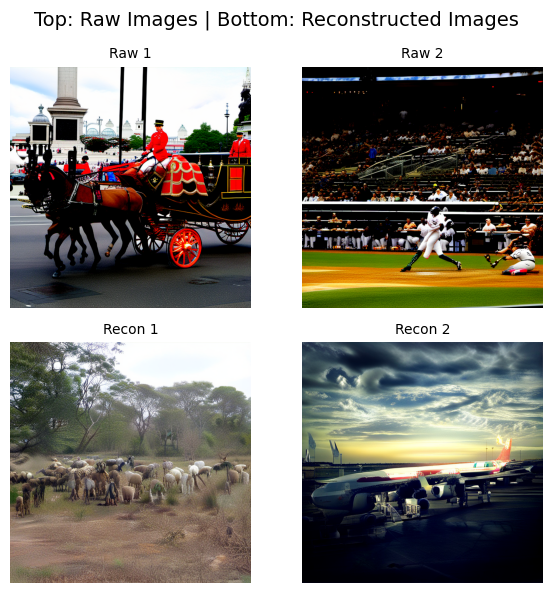

In [8]:
sample_clip = mindeyev2_generate(mindeyev2, val_fmri.unsqueeze(1).to('cuda:1'))

train_fmri2img = sdxl_recon_combined(diffusion_engine, vector_suffix, sample_clip, train_clip, num_samples=2)
plt.show()

In [ ]:
device = 'cuda:0'

brain_enc = load_brain_vae(args).to(device).eval()
requires_grad(brain_enc, False)
print("params of brain encoder:")
count_params(brain_enc)

16.3835 -14.257167
Valid Voxel Sub1: (1000, 15724)
Valid Clip Sub1: (1000, 256, 1664)
Testing batch size: 64
Dataset samples: fmri-1000 feature-1000

Done with Data preparations!
torch.Size([64, 1, 4096])
torch.Size([64, 256, 1664]) torch.Size([64, 256, 1664])


sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

/home/bingxing2/ailab/maiweijian/.conda/envs/BrainVL/lib/python3.10/site-packages/torch/utils/checkpoint.py:426: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/bingxing2/ailab/maiweijian/.conda/envs/BrainVL/lib/python3.10/site-packages/torch/utils/checkpoint.py:59: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


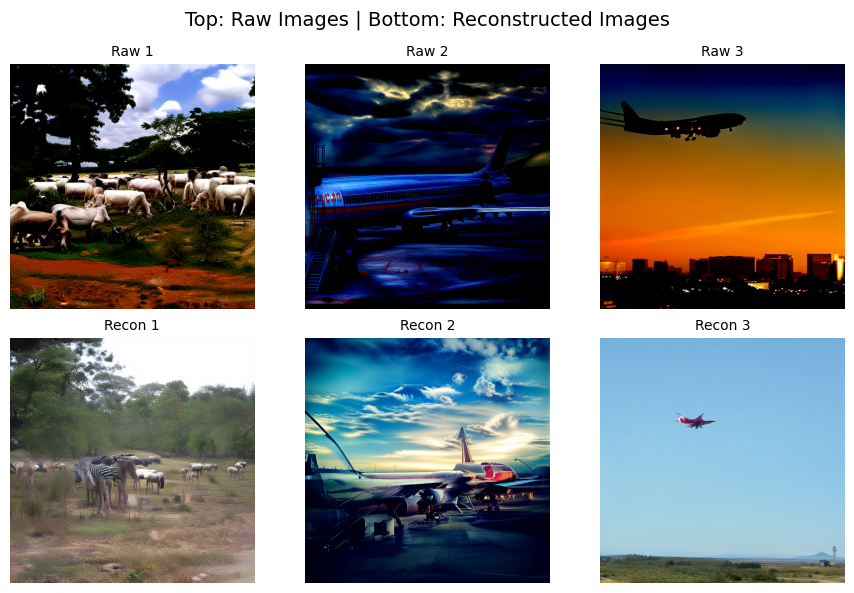

In [12]:
args.test_batch_size = 64
test_dataloader = multisub_clip_test_dataset(args)

test_fmri, test_clip, test_sub = next(iter(test_dataloader))
test_length = test_fmri.shape[-1]
test_clip = test_clip.float().to(device)

# 加载保存好的标准化参数
norm_params = np.load('norm_mean_scale_sub1.npz')

norm_mean_train = norm_params['mean']
norm_scale_train = norm_params['scale']

# 使用加载的均值和标准差进行标准化
test_fmri = (test_fmri - norm_mean_train) / norm_scale_train

sample_clip = mindeyev2_generate(mindeyev2, test_fmri.unsqueeze(1).to('cuda:1'))

train_fmri2img = sdxl_recon_combined(diffusion_engine, vector_suffix, sample_clip, test_clip, num_samples=3)
plt.show()

In [ ]:
import h5py

voxels = {}
# Load hdf5 data for betas
data_path = "/home/bingxing2/ailab/group/ai4neuro/mindeyev2"
subj = 1
new_test = True

f = h5py.File(f'{data_path}/betas_all_subj0{subj}_fp32_renorm.hdf5', 'r')
betas = f['betas'][:]
betas = torch.Tensor(betas).to("cpu")
num_voxels = betas[0].shape[-1]
voxels[f'subj0{subj}'] = betas
print(f"num_voxels for subj0{subj}: {num_voxels}")

if not new_test: # using old test set from before full dataset released (used in original MindEye paper)
    if subj==3:
        num_test=2113
    elif subj==4:
        num_test=1985
    elif subj==6:
        num_test=2113
    elif subj==8:
        num_test=1985
    else:
        num_test=2770
    test_url = f"{data_path}/wds/subj0{subj}/test/" + "0.tar"
else: # using larger test set from after full dataset released
    if subj==3:
        num_test=2371
    elif subj==4:
        num_test=2188
    elif subj==6:
        num_test=2371
    elif subj==8:
        num_test=2188
    else:
        num_test=3000
    test_url = f"{data_path}/wds/subj0{subj}/new_test/" + "0.tar"
    
print(test_url)
def my_split_by_node(urls): return urls
test_data = wds.WebDataset(test_url,resampled=False,nodesplitter=my_split_by_node)\
                    .decode("torch")\
                    .rename(behav="behav.npy", past_behav="past_behav.npy", future_behav="future_behav.npy", olds_behav="olds_behav.npy")\
                    .to_tuple(*["behav", "past_behav", "future_behav", "olds_behav"])
test_dl = torch.utils.data.DataLoader(test_data, batch_size=num_test, shuffle=False, drop_last=True, pin_memory=True)
print(f"Loaded test dl for subj{subj}!\n")

In [ ]:
# Prep images but don't load them all to memory
# f = h5py.File(f'{data_path}/coco_images_224_float16.hdf5', 'r')
# images = f['images']

# Prep test voxels and indices of test images
test_images_idx = []
test_voxels_idx = []
for test_i, (behav, past_behav, future_behav, old_behav) in enumerate(test_dl):
    test_voxels = voxels[f'subj0{subj}'][behav[:,0,5].cpu().long()]
    mean_ = torch.mean(test_voxels)
    std_ = torch.std(test_voxels)
    max_ = torch.max(test_voxels)
    min_ = torch.min(test_voxels)
    print(mean_, std_)
    print(max_, min_)
    test_voxels_idx = np.append(test_images_idx, behav[:,0,5].cpu().numpy())
    test_images_idx = np.append(test_images_idx, behav[:,0,0].cpu().numpy())
test_images_idx = test_images_idx.astype(int)
test_voxels_idx = test_voxels_idx.astype(int)

assert (test_i+1) * num_test == len(test_voxels) == len(test_images_idx)
print(test_i, len(test_voxels), len(test_images_idx), len(np.unique(test_images_idx)))

In [ ]:
sample_clip_raw = mindeyev2_generate(mindeyev2, test_voxels[:5].unsqueeze(1).to('cuda:1'))

train_fmri2img = sdxl_recon_combined(diffusion_engine, vector_suffix, sample_clip_raw, train_clip, num_samples=5)
plt.show()

In [ ]:
# 计算 test_voxels 的均值和标准差
mean = test_voxels.mean(dim=0, keepdim=True)
std = test_voxels.std(dim=0, keepdim=True)

print("test voxels mean:", test_voxels.mean().item())
print("test voxels std:", test_voxels.std().item())

train_fmri_norm = std_normalize(train_fmri)
print(torch.mean(train_fmri_norm), torch.std(train_fmri_norm))

train_fmri_normalized = train_fmri_norm * std + mean 
print(torch.mean(train_fmri_normalized), torch.std(train_fmri_normalized))

# 打印标准化后的 mean 和 std
print("Standardized train_fmri mean:", train_fmri_normalized.mean().item())
print("Standardized train_fmri std:", train_fmri_normalized.std().item())

In [ ]:
sample_clip_raw = mindeyev2_generate(mindeyev2, train_fmri_normalized.unsqueeze(1).to('cuda:1'))

train_fmri2img = sdxl_recon_combined(diffusion_engine, vector_suffix, sample_clip_raw, train_clip, num_samples=5)
plt.show()

In [ ]:
import torch

# 假设
# test_images_idx: (num_total_samples,)  比如 tensor([0,0,0,1,1,1,2,2,2])
# test_voxels: (num_total_samples, feature_dim) 比如 tensor(9, 10000)

# 获取所有唯一图像编号
unique_img_idx = np.unique(test_images_idx)
unique_img_idx = np.sort(unique_img_idx)

# 新建一个list，存每张图片平均后的voxel
merged_voxels = []

for idx in unique_img_idx:
    idx_mask = (test_images_idx == idx)  # boolean mask
    voxels_of_this_img = test_voxels[idx_mask]  # (3, feature_dim)
    mean_voxel = voxels_of_this_img.mean(dim=0)  # 对第0维求均值
    merged_voxels.append(mean_voxel)

# 拼成一个新的tensor
merged_voxels = torch.stack(merged_voxels, dim=0)  # (num_images, feature_dim)

print(merged_voxels.shape)

In [ ]:
import torch
import numpy as np

merged_voxels = []
merged_idx = []

processed_idx = set()

for i in range(len(test_images_idx)):
    current_idx = test_images_idx[i]
    if current_idx in processed_idx:
        continue

    # 用numpy找位置
    same_idx_positions = np.where(test_images_idx == current_idx)[0]

    # 拿出这3个voxel，平均
    voxels_of_this_img = test_voxels[same_idx_positions]
    mean_voxel = voxels_of_this_img.mean(dim=0)

    merged_voxels.append(mean_voxel)
    merged_idx.append(current_idx)

    processed_idx.add(current_idx)

# 拼接
merged_voxels = torch.stack(merged_voxels, dim=0)  # torch tensor
merged_idx = np.array(merged_idx, dtype=int)       # numpy array

print(merged_voxels.shape)
print(merged_idx.shape)

In [ ]:
merged_idx

In [ ]:
sample_clip_raw = mindeyev2_generate(mindeyev2, merged_voxels[:5].unsqueeze(1).to('cuda:1'))

train_fmri2img = sdxl_recon_combined(diffusion_engine, vector_suffix, sample_clip_raw, train_clip, num_samples=5)
plt.show()